In [4]:
# Add any necessary imports here (as we go along)
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import torch
# import torch.nn as nn

Number of entries: 2408


Raw data:
         Date        Open       Close
0  2015-01-02  151.500000  149.169998
1  2015-01-05  148.809998  147.000000
2  2015-01-06  147.639999  146.839996
3  2015-01-07  147.940002  148.880005
4  2015-01-08  150.600006  151.369995
5  2015-01-09  151.649994  149.470001
6  2015-01-12  149.960007  148.279999
7  2015-01-13  149.949997  148.630005
8  2015-01-14  147.270004  147.820007
9  2015-01-15  148.529999  147.580002


After curating data:
      Date         Mid
0  2457024  150.334999
1  2457027  147.904999
2  2457028  147.239998
3  2457029  148.410004
4  2457030  150.985001
5  2457031  150.559998
6  2457034  149.120003
7  2457035  149.290001
8  2457036  147.545006
9  2457037  148.055000


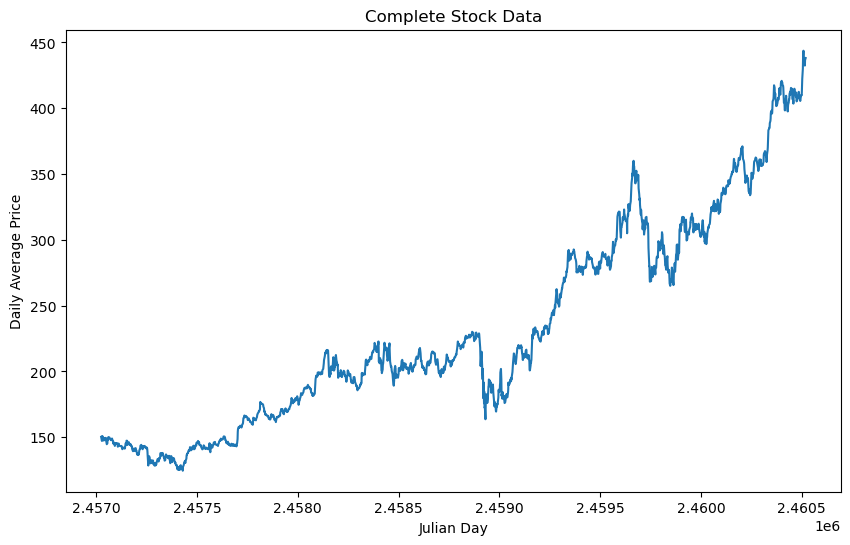

In [5]:
# Parse CSV
# Data pulled from https://www.kaggle.com/datasets/umerhaddii/berkshire-hathaway-stock-price-data
# Using the data curation from https://github.com/hemangjoshi37a/TrendMaster/blob/main/trendmaster/data_loader.py
firstDF = pd.read_csv('stocks.csv')[['Date', 'Open', 'Close']]
print("Number of entries:", len(firstDF['Date'].values))
print("\n\nRaw data:")
print(firstDF.head(10))

# Get Julian day and average the open and close values for the day as a new column, "Mid"
firstDF['Date'] = firstDF['Date'].apply(lambda x: pd.to_datetime(x).to_julian_date().astype(int))
firstDF['Mid'] = (firstDF['Open'] + firstDF['Close']) / 2
firstDF = firstDF.drop(columns=['Open', 'Close'])
print("\n\nAfter curating data:")
print(firstDF.head(10))

# Display data
plt.figure(figsize=(10, 6))
plt.plot(firstDF['Date'].values, firstDF['Mid'].values)
plt.title("Complete Stock Data")
plt.xlabel("Julian Day")
plt.ylabel("Daily Average Price")
plt.show()

[2457024 2457027 2457028 ... 2460516 2460517 2460520]
[2457024 2457027 2457028 ... 2459814 2459815 2459816]


NameError: name 'set_facecolor' is not defined

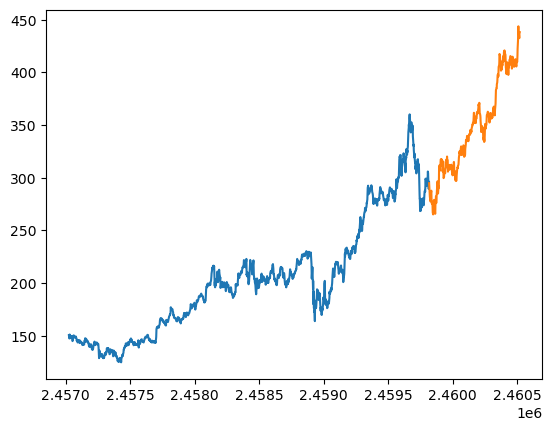

In [64]:
# Convert raw dataframe into average price over time


# Split this data into train and test data
# pick an indice to split on 
X = np.squeeze(firstDF[['Date']].values)
# print(X)
y = np.squeeze(firstDF[['Mid']].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# X_train = np.squeeze(X_train)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
plt.figure()
plt.clf()
# plt.plot([1, 2, 3, 4, 5], [5, 3, 2, 3, 5])
plt.plot(X_train, y_train, label="Train")
# print(X_train)
plt.plot(X_test, y_test, label="Test")
# plt.figure(set_facecolor('lightgray'))
plt.legend()
plt.show()

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform((X_train))

# # Scale the test data
# X_test_scaled = scaler.transform((X_test))

# plt.plot(X_train_scaled, label="X-train")
# plt.plot(X_test_scaled)

# NOTE: It is important that we do this BEFORE chopping up the data into distinct windows! Otherwise, there will be data leakage.
# Plot this data


# Read this README.md https://github.com/lkulowski/LSTM_encoder_decoder/tree/master
# Create a scrolling window based on two parameters: input size and target size

In [18]:
# Define the model architecture

class Seq2seq(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers = 1):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.encoder = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.decoder = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''
        
        encoder_out, self.hidden = self.encoder(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        decoder_out, self.hidden = self.decoder(encoder_out, self.hidden)
        output = self.linear(decoder_out.squeeze(0))
        
        return output, self.hidden

# Model's Input: list, where a number corresponds to the average price of a stock for that day
# Read the model definition here (the Encoder-Decoder LSTM network) https://github.com/lkulowski/LSTM_encoder_decoder/blob/master/code/lstm_encoder_decoder.py

# Perhaps wishful thinking, but it would be nice to provide an example evaluation of input data before training

In [19]:
# Define the train/test loop?
# We need to figure out the dataloader necessary before we start the train and test loop

In [20]:
# Run the train/test loop
# Display results
# Profit (⌐▨_▨) . 